<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/cnn_amber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.callbacks import LearningRateScheduler
 
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.004
    drop = 0.5
    epochs_drop = 40.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

2023-02-24 13:56:41.689885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
img_rows = 50
img_cols = 50
epochs = 200
batch_size = 1*32
num_of_train_samples = 1265
num_of_test_samples = 505
num_of_val_samples = 200

In [ ]:
#part2-fitting the cnn to the images
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)

In [ ]:
# Generating images for the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
# Creating training set
training_set = train_datagen.flow_from_directory('/home/arulipn/Untitled Folder/train',
                                                 target_size = (img_rows, img_cols),
                                                 batch_size = batch_size,
                                                 shuffle = True,
                                                 class_mode = 'categorical')
# Creating the Test set
test_set = test_datagen.flow_from_directory('/home/arulipn/Untitled Folder/test',
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            shuffle = False,
                                            class_mode = 'categorical')

# Creating the Test set
valid_set = test_datagen.flow_from_directory('/home/arulipn/Untitled Folder/val',
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            shuffle = False,
                                            class_mode = 'categorical')

Found 1265 images belonging to 20 classes.
Found 504 images belonging to 20 classes.
Found 200 images belonging to 20 classes.


In [ ]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Making Sppnet custom layer
# Try refering github implementation
# Refer https://keras.io/layers/writing-your-own-keras-layers/
# or https://keras.io/examples/antirectifier/
import sys
from keras.layers import Layer
from keras import backend as K

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

BATCH = 20

class SppnetLayer(Layer):
    '''This layer takes an input tensor and pools the tensor
      in local spatial bins.
      This layer uses Max pooling.
      It accepts input in tensorflow format. # channels last

    # Input
        list of filter in form [x,y,z] 
    # Input shape : 4d tensor [None, X,Y, channels]
    # Output shape : 3d tensor [None,pooled dim, channels] 

    '''
    def __init__(self, filters = [1], **kwargs):
        self.filters = filters
        super(SppnetLayer, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        length = 0;
        for f_size in self.filters:
            length+= (f_size*f_size)
        return (input_shape[0],length*input_shape[3])
      
    def get_config(self):
        config = {'filters': self.filters}
        base_config = super(SppnetLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
      output = []
      for f_size in self.filters:
        win_size = K.int_shape(inputs)[1]/f_size
        #print(win_size)
        win_size = int(win_size)
        for x_start in range(0,f_size):
          for y_start in range(0,f_size):
            X = int(x_start*win_size)
            Y = int(y_start*win_size)
            result = K.max(inputs[:,X:X+win_size,Y:Y+win_size,:],axis = (1,2))
            output.append(result)
      output = K.concatenate(output)
      return output

In [ ]:
model=Sequential()

model.add(Conv2D(8,(3,3),activation='relu',input_shape=(img_rows,img_cols,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.5))

model.add(Conv2D(7,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.5))

model.add(Conv2D(7,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.5))

#model.add(SppnetLayer([1,2,4])) #To implement SppNet 
model.add(Flatten())

model.add(Dense(20,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(20,activation='softmax'))

model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop' ,metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 8)         224       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 7)         511       
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 7)        28        
 hNormalization)                                                 
                                                        

2023-02-24 13:56:43.523578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 13:56:43.533193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 13:56:43.534996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 13:56:43.537604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
earlystop = EarlyStopping(patience = 50,verbose = 1)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 15,verbose = 1,factor = 0.99,min_lr = 0.0001)
mcp_save = ModelCheckpoint('/home/arulipn/Untitled Folder/mdl_wts1.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
callbacks = [mcp_save] #, LearningRateScheduler(step_decay)] #[earlystop,learning_rate_reduction]

In [ ]:
history = model.fit_generator(training_set,steps_per_epoch=num_of_train_samples // batch_size,epochs=epochs, validation_data=test_set, validation_steps=num_of_test_samples // batch_size, callbacks=callbacks)

Epoch 1/200


2023-02-24 13:56:46.439990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-02-24 13:56:47.303652: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-24 13:56:47.422705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-24 13:56:47.426731: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55e51b756700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-24 13:56:47.426773: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-02-24 13:56:47.432703: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-24 13:56:47.505790:

39/39 [==============================] - 6s 55ms/step - loss: 3.0253 - accuracy: 0.1403 - val_loss: 2.9517 - val_accuracy: 0.1271
Epoch 2/200
39/39 [==============================] - 2s 48ms/step - loss: 2.4326 - accuracy: 0.2530 - val_loss: 2.9088 - val_accuracy: 0.0979
Epoch 3/200
39/39 [==============================] - 2s 50ms/step - loss: 2.1096 - accuracy: 0.3504 - val_loss: 2.8689 - val_accuracy: 0.1396
Epoch 4/200
39/39 [==============================] - 2s 49ms/step - loss: 1.9104 - accuracy: 0.3844 - val_loss: 2.9147 - val_accuracy: 0.1833
Epoch 5/200
39/39 [==============================] - 2s 49ms/step - loss: 1.7398 - accuracy: 0.4298 - val_loss: 2.9113 - val_accuracy: 0.1937
Epoch 6/200
39/39 [==============================] - 2s 48ms/step - loss: 1.6082 - accuracy: 0.4623 - val_loss: 2.9252 - val_accuracy: 0.1813
Epoch 7/200
39/39 [==============================] - 2s 49ms/step - loss: 1.5152 - accuracy: 0.5020 - val_loss: 2.8679 - val_accuracy: 0.2396
Epoch 8/200
39/39 

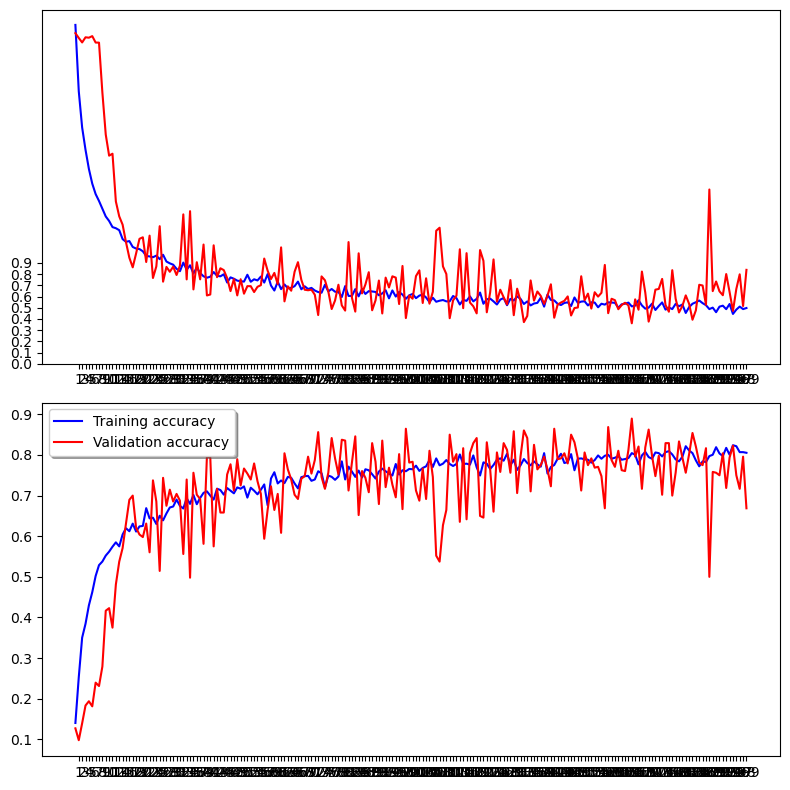

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
model.load_weights('/home/arulipn/Untitled Folder/mdl_wts1.hdf5')
y_pred = model.predict_generator(test_set, steps = 505 // batch_size+1, verbose=1)
from sklearn.metrics import classification_report, confusion_matrix
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['N01', 'N02', 'N03','N04','N05','N06','N07','N08','N09','N10','N11','N12','N13','N14','N15','N16','N17','N18','N19','N20']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

16/16 [==============================] - 0s 22ms/step
Confusion Matrix
[[31  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 26  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2 27  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 28  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 21  4  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 12  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2 13  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2 12  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  3  0  0  0  0 39  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  1 18 